In [139]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

import matplotlib.pyplot as plt
import contextily as ctx
plt.style.use('seaborn')
%matplotlib inline

# Cleaning for Bike Accidents

We can only use points with an MO and only those involving bikes

In [5]:
accidents = pd.read_csv('./Data/Traffic_Collision_Data_from_2010_to_Present.csv', parse_dates=['Date Reported', 'Date Occurred'])

In [9]:
accidents.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,Victim Age,Victim Sex,Victim Descent,Premise Code,Premise Description,Address,Cross Street,Location
0,190211527,2019-05-18,2019-05-18,110,2,Rampart,279,997,TRAFFIC COLLISION,3101 3401 3701 3004 3030,33.0,F,H,101.0,STREET,UNION,JAMES M WOOD,"(34.0508, -118.2731)"
1,110518459,2011-10-11,2011-10-11,1735,5,Harbor,505,997,TRAFFIC COLLISION,0506,27.0,F,O,101.0,STREET,VERMONT,KNOX,"(33.8542, -118.2905)"
2,180618348,2018-08-09,2018-08-09,1830,6,Hollywood,665,997,TRAFFIC COLLISION,3004 3028 3030 3035 3036 3101 3401 3701 4006,33.0,M,W,101.0,STREET,FRANKLIN AV,ARGYLE,"(34.1052, -118.3252)"
3,120312271,2012-05-09,2012-05-09,845,3,Southwest,331,997,TRAFFIC COLLISION,NaN,51.0,M,B,101.0,STREET,LA BREA AV,JEFFERSON BL,"(34.0255, -118.3548)"
4,121215287,2012-06-13,2012-06-13,745,12,77th Street,1208,997,TRAFFIC COLLISION,0605,48.0,F,B,101.0,STREET,48TH ST,FIGUEROA,"(33.9997, -118.2827)"


In [8]:
accidents['MO Codes'].notnull().sum()

444034

In [40]:
mo_codes = {}
with open('./Data/MO Codes Cleanup.csv') as f:
    f.readline()#throwaway headers
    for row in f.readlines():
        try:
            code, desc = row.replace('\n', '').split(',', 1)
            code_full = code.zfill(4)
            mo_codes[code_full] = desc
        except:
            print(row)

In [41]:
test_codes = accidents.loc[0, 'MO Codes'] #split on space
test_codes

'3101 3401 3701 3004 3030'

In [62]:
def transformBikeAccidents(mo_string):
    descriptions = [mo_codes.get(code) for code in mo_string.split(' ') if mo_codes.get(code)]
    return descriptions

In [63]:
transformBikeAccidents(test_codes)

['T/C - PCF (A) In the Narrative',
 'T/C - Type of Collision',
 'T/C - Movement Preceding Collision',
 'T/C-VehvsVeh',
 'T/C - Hit and Run Misd']

In [67]:
accidents['Bike Accidents'] = accidents['MO Codes'].map(lambda codes: transformBikeAccidents(str(codes)) if codes else [])
has_bike = accidents['Bike Accidents'].map(lambda descriptions: any([desc for desc in descriptions if 'bike' in desc.lower()]))

In [93]:
bike_accidents = accidents[has_bike].copy()

In [94]:
bike_accidents.assign(year = bike_accidents['Date Occurred'].map(lambda date: date.year))\
        .year\
        .value_counts()\
        .sort_index()

2010      18
2011      38
2012    2086
2013    2567
2014    2392
2015    2352
2016    2132
2017    2163
2018    2069
2019    1993
2020     768
Name: year, dtype: int64

So the potentially good news is that bike accidents have been going down in Los Angeles.  This is still wide open since we don't know if we just have less bikers (which may be the case for 2020), reporting has changed, etc.

# Bike Lane Safety

## Are Bike Lanes Roads Safer Than Others?

In counting the number of accidents, one naive idea is to normalize the number of accidents by length of road.  When that road became a bike lane should also be taken into consideration relative to the accident occurence.  There is also the possibility that bike lanes may have been installed in response to accidents or danger, so it's unfair to compare accident counts of one road to another.  Subjects such as possibly comparing a road to itself after it became a bike lane as well as normalizing according to historic volume as opposed to street length will be visited later.

### Preparing GeoDataFrames

Bike routes were in latitude/longitude, just match these:

In [129]:
def plotCrimePoint(coords):
    lat, lon = [float(coord) for coord in coords[1:-1].split(',')]
    return Point(lon, lat)

In [131]:
bike_accidents['geometry'] = bike_accidents.Location.map(plotCrimePoint)
bike_accidents_geo = gpd.GeoDataFrame(bike_accidents, crs='EPSG:4326')

Some don't have exact locations, let's just lose these since they aren't too many.

In [132]:
bike_accidents_geo[bike_accidents_geo.geometry == Point(0,0)].shape

(19, 20)

In [133]:
bike_accidents_geo = bike_accidents_geo[bike_accidents_geo.geometry != Point(0,0)].copy()

In [85]:
bike_lanes = gpd.read_file('./Data/City_of_Los_Angeles_Bikeways-shp/28de79f7-8e83-4ea9-923b-45b6accc9fad2020329-1-1hi0fjx.3l8l.shp')

In [117]:
bike_lanes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

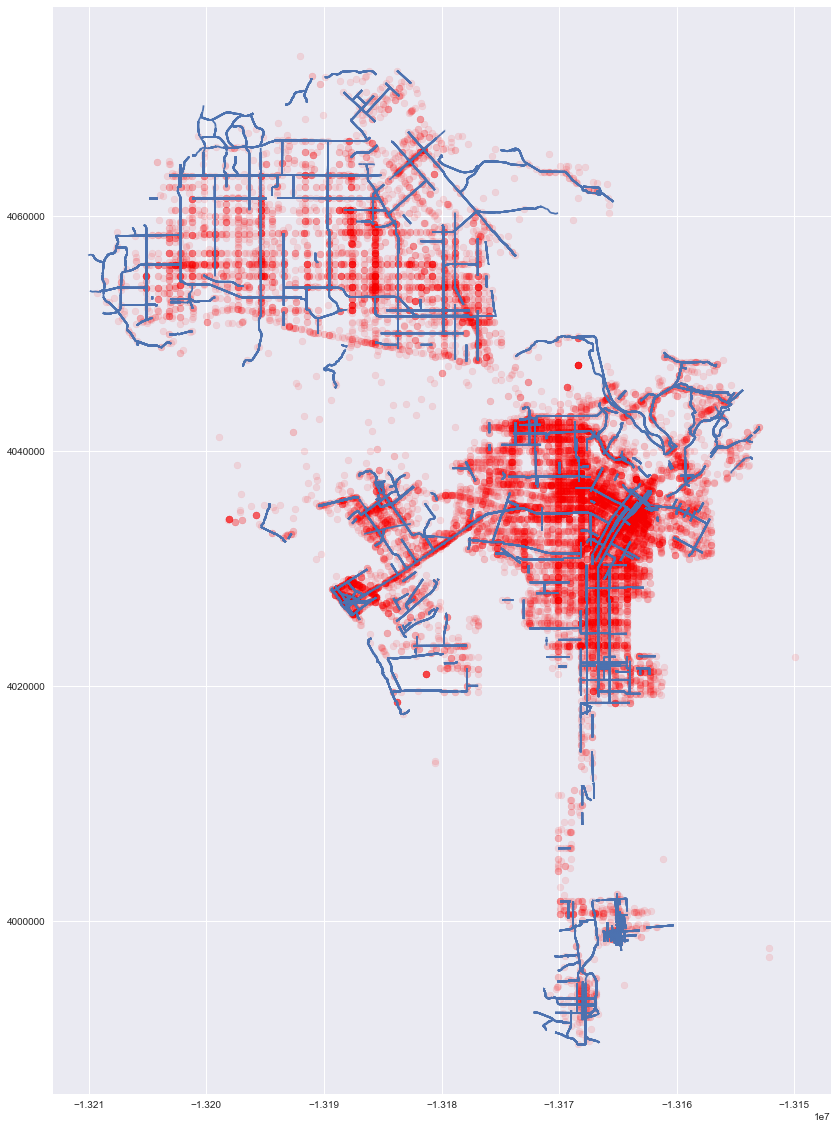

In [171]:
ax = bike_accidents_geo.to_crs('epsg:3857')\
        .plot(color='red', alpha=.1, figsize=(20,20))

bike_lanes.to_crs('epsg:3857')\
        .plot(ax=ax)

#fix basemap
#ctx.add_basemap(ax, zoom=17, source=ctx.providers.CartoDB.Voyager)

We will classify each accident according to whether they are near a bike lane, and those that are will be classified for whether they occured before or after 